# Plotting the maximum radius and corresponding P_ZAMS

When computing the formation efficiency, one factor that comes into play is the range of periods of stars that interact

To estimate this, I want to plot the maximum radius of stars at different metallicities for a typical BH and NS progenitor star, and then plot the corresponging P_ZAMS 

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import h5py as h5
from matplotlib.colors import ListedColormap
from astropy.table import Table

from astropy import constants as const
from astropy import units as u

home_dir = os.path.expanduser("~")

######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('text', usetex=False)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,18,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


######################################
sim_name        = "OldWinds_RemFryer2012" # sim_name determines which flags to run COMPAS with
root_out_dir    = f"/mnt/home/lvanson/ceph/CompasOutput/v02.46.01/{sim_name}"


# Load the Single star grid data

In [2]:
# Mapping types to names 
Stellar_Type_table = Table()
Stellar_Type_table['types'] = ['MS_low', 'MS' ,'HG', 'AGB', 'CHeB', 'EAGB','TPAGB','HeMS','HeHG','HeGB','HeWD','COWD','ONeWD','NS','BH','massless remnant']
Stellar_Type_table['indices'] = np.arange(len(Stellar_Type_table))

# NEW mass loss types
Wind_prescr_table = Table()
Wind_prescr_table['types'] = ['NONE', 'OB', 'VMS', 'GB', 'RSG', 'WR', 'LBV']
Wind_prescr_table['indices'] = np.arange(len(Wind_prescr_table))

# # Old mass loss types
# Wind_prescr_table = Table()
# Wind_prescr_table['types'] = ['None', 'Nieuwenhuijzen and de Jager', 'Kudritzki and Reimers', 'Vassiliadis and Wood', 'Wolf-Rayet-like (Hamann, Koesterke and de Koter)', 'Vink', 'Luminous Blue Variable']
# Wind_prescr_table['indices'] = np.arange(len(Wind_prescr_table))


def get_max_radii(loc = '{root_out_dir}/SingleStarGrids/SingleStars_M10/'):
    Metals, maxRadii, maxR_type, maxR_massloss    = [],  [],  [],  []

    for i in range(100):
        # Read detailed hdf5 file
        detailed_data = f'{loc}/Detailed_Output/BSE_Detailed_Output_{i}.h5'
        detailh5 = h5.File(detailed_data, 'r')

        # Get the relevant info out
        i_maxR = np.argmax(detailh5['Radius(1)'][()])
        Metals.append(detailh5['Metallicity@ZAMS(1)'][0])
        maxRadii.append( detailh5['Radius(1)'][i_maxR] )
        maxR_type.append(detailh5['Stellar_Type(1)'][i_maxR])   
        maxR_massloss.append(detailh5['Dominant_Mass_Loss_Rate(1)'][i_maxR])

        maxR_RL1 = np.max(detailh5['Radius(1)'][()]/detailh5['RocheLobe(1)'][()]) 
        if maxR_RL1 > 1.0:
            print(f'Watch out!RL1: {maxR_RL1} for {i}')
        maxR_RL2 = np.max(detailh5['Radius(2)'][()]/detailh5['RocheLobe(2)'][()]) 
        if maxR_RL2 > 1.0:
            print(f'Watch out! RL2: {maxR_RL2} for {i}')
    return Metals, maxRadii, maxR_type, maxR_massloss

In [3]:
# Initialize an empty dictionary
data = {
    'M0': [],
    'Metals': [],
    'maxRadii': [],
    'maxR_type': [],
    'maxR_massloss': [],
    #
    'R_ZAMS': [],
    'maxR_MS': [],
    'maxR_HG': [],
    'maxR_FGB': [],
    'maxR_CHeB': [],
    'maxR_EAGB': [],
    #
    'Luminosity': [],
    'Teff': [],
    'Radius': [],
    'Mass': [],
    'Stellar_Type': [],
    'Dominant_Wind': []
}

# For each mass, compute the values and append them to the lists
for mass in [10, 20, 30, 40, 50, 60, 70,90, 100, 150]:
    print('mass', mass)

    read_loc =  f'{root_out_dir}/SingleStarGrids/SingleStars_M{mass}/'

    print('reading ', read_loc)
    
    try:
        Metals, maxRadii, maxR_type, maxR_massloss   = [],  [],  [],  []
        R_ZAMS, maxR_MS, maxR_HG, maxR_FGB, maxR_CHeB, maxR_EAGB = [], [], [], [], [], []
        L, Teff, M, Radius, stellar_type, dominant_wind = [], [], [], [], [], []

        for i in range(100):
            # Read detailed hdf5 file
            detailh5 = h5.File(f'{read_loc}/Detailed_Output/BSE_Detailed_Output_{i}.h5', 'r')

            ####################################### 
            # Maximum radius at all times
            i_maxR = np.argmax(detailh5['Radius(1)'][()])
            Metals.append(detailh5['Metallicity@ZAMS(1)'][0])
            maxRadii.append( detailh5['Radius(1)'][i_maxR] )
            maxR_type.append(detailh5['Stellar_Type(1)'][i_maxR])   
            maxR_massloss.append(detailh5['Dominant_Mass_Loss_Rate(1)'][i_maxR])

            #######################################
            # Select the maximum radius for each stellar type
            R_ZAMS.append(detailh5['Radius(1)'][0])

            st1 = detailh5['Stellar_Type(1)'][()]
            MS_bool = np.logical_or(st1 == 0, st1 == 1)
            maxR_MS.append(max(detailh5['Radius(1)'][MS_bool]) )

            HG_bool = st1 == 2
            maxR_HG.append(max(detailh5['Radius(1)'][HG_bool]) if np.any(HG_bool) > 0 else 0)

            FGB_bool = st1 == 3
            maxR_FGB.append(max(detailh5['Radius(1)'][FGB_bool]) if np.any(FGB_bool) > 0 else 0)
            
            CHeB_bool = st1 == 4
            maxR_CHeB.append(max(detailh5['Radius(1)'][CHeB_bool]) if np.any(CHeB_bool) > 0 else 0 )

            EAGB_bool = st1 == 5
            maxR_EAGB.append(max(detailh5['Radius(1)'][EAGB_bool]) if np.any(EAGB_bool) > 0 else 0 )

            #######################################
            # For HR diagram
            L.append(detailh5['Luminosity(1)'])
            Teff.append(detailh5['Teff(1)'])
            Radius.append(detailh5['Radius(1)'])
            M.append(detailh5['Mass(1)'])
            stellar_type.append(detailh5['Stellar_Type(1)'])
            dominant_wind.append(detailh5['Dominant_Mass_Loss_Rate(1)'])

            maxR_RL1 = np.max(detailh5['Radius(1)'][()]/detailh5['RocheLobe(1)'][()]) 
            if maxR_RL1 > 1.0:
                print(f'Watch out! maxR_RL1: {maxR_RL1} for {i}')
            maxR_RL2 = np.max(detailh5['Radius(2)'][()]/detailh5['RocheLobe(2)'][()]) 
            if maxR_RL2 > 1.0:
                print(f'Watch out! maxR_RL2: {maxR_RL2} for {i}')
                    
        # Max R
        data['M0'].append(mass)
        data['Metals'].append(Metals)
        data['maxRadii'].append(maxRadii)
        data['maxR_type'].append(maxR_type)
        data['maxR_massloss'].append(maxR_massloss)

        # Max R per type
        data['R_ZAMS'].append(R_ZAMS)
        data['maxR_MS'].append(maxR_MS)
        data['maxR_HG'].append(maxR_HG)
        data['maxR_FGB'].append(maxR_FGB)
        data['maxR_CHeB'].append(maxR_CHeB)
        data['maxR_EAGB'].append(maxR_EAGB)

        # HR
        data['Luminosity'].append(L)
        data['Teff'].append(Teff)   
        data['Radius'].append(Radius)  
        data['Mass'].append(M)  
        data['Stellar_Type'].append(stellar_type)  
        data['Dominant_Wind'].append(dominant_wind)  

    except Exception as e:
        print('ERR:', e)
        traceback.print_exc()
        continue


print(data['M0'])

mass 10
reading  /mnt/home/lvanson/ceph/CompasOutput/v02.46.01/OldWinds_RemFryer2012/SingleStarGrids/SingleStars_M10/
mass 20
reading  /mnt/home/lvanson/ceph/CompasOutput/v02.46.01/OldWinds_RemFryer2012/SingleStarGrids/SingleStars_M20/
mass 30
reading  /mnt/home/lvanson/ceph/CompasOutput/v02.46.01/OldWinds_RemFryer2012/SingleStarGrids/SingleStars_M30/
mass 40
reading  /mnt/home/lvanson/ceph/CompasOutput/v02.46.01/OldWinds_RemFryer2012/SingleStarGrids/SingleStars_M40/
mass 50
reading  /mnt/home/lvanson/ceph/CompasOutput/v02.46.01/OldWinds_RemFryer2012/SingleStarGrids/SingleStars_M50/
mass 60
reading  /mnt/home/lvanson/ceph/CompasOutput/v02.46.01/OldWinds_RemFryer2012/SingleStarGrids/SingleStars_M60/
mass 70
reading  /mnt/home/lvanson/ceph/CompasOutput/v02.46.01/OldWinds_RemFryer2012/SingleStarGrids/SingleStars_M70/
mass 90
reading  /mnt/home/lvanson/ceph/CompasOutput/v02.46.01/OldWinds_RemFryer2012/SingleStarGrids/SingleStars_M90/
mass 100
reading  /mnt/home/lvanson/ceph/CompasOutput/v0

mass 40 3


/tmp/ipykernel_157258/1971839002.py:29: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_FGB'][mi]), c = "#72bfc2", s = 20, label = "FGB")
/tmp/ipykernel_157258/1971839002.py:35: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_EAGB'][mi]), c = "#19445c", s = 20, label = "EAGB")


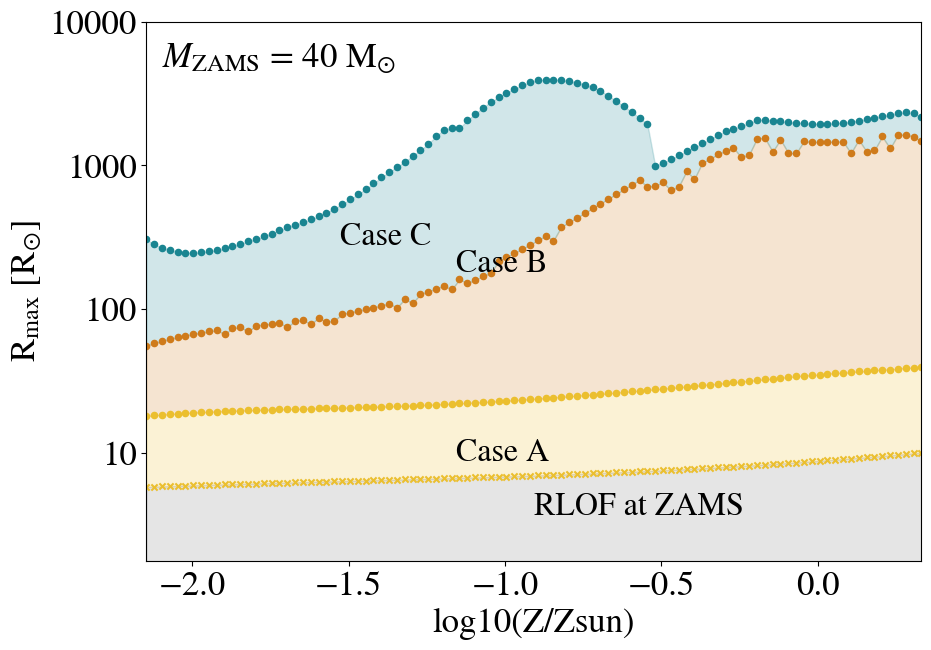

mass 10 0


/tmp/ipykernel_157258/1971839002.py:29: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_FGB'][mi]), c = "#72bfc2", s = 20, label = "FGB")


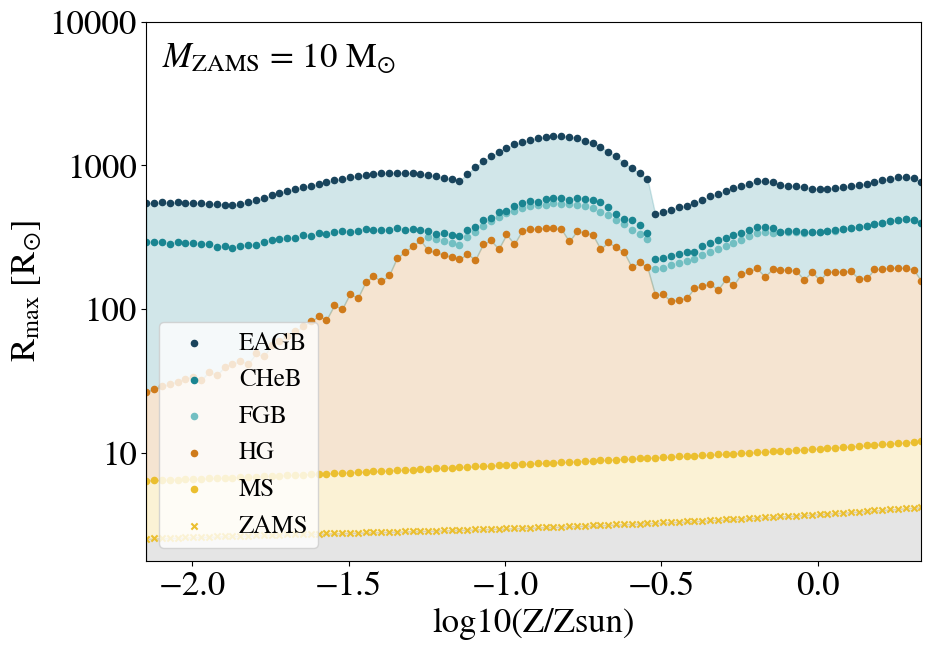

In [9]:


def plot_maxR_CaseABC(mass, show_legend = True, show_annotations = False):
    """
    Plot the maximum radius for each type of star as a function of metallicity
    """
    mi = data['M0'].index(mass)
    print('mass', mass, mi)

    fig, ax = plt.subplots(figsize =(10,7))

    plt.fill_between(np.log10(np.array(data['Metals'][mi])/0.014), y1 =0, y2 = np.log10(data['R_ZAMS'][mi]),  color = 'grey', alpha = 0.2)

    # R_ZAMS
    plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['R_ZAMS'][mi]), c = '#ebbf2f', s = 20, marker = 'x', label = 'ZAMS')

    # Case A is up to max MS
    plt.fill_between(np.log10(np.array(data['Metals'][mi])/0.014), y1 = np.log10(data['R_ZAMS'][mi]), y2 = np.log10(data['maxR_MS'][mi]),  color = '#ebbf2f', alpha = 0.2)

    #Case B is between MS and HG 
    plt.fill_between(np.log10(np.array(data['Metals'][mi])/0.014), y1 = np.log10(data['maxR_MS'][mi]), y2 = np.log10(data['maxR_HG'][mi]),  color = '#cf7b1b', alpha = 0.2)

    # Case C is beyond HG
    plt.fill_between(np.log10(np.array(data['Metals'][mi])/0.014), y1 = np.log10(data['maxR_HG'][mi]), y2 = np.log10(data['maxRadii'][mi]),  color = '#1a8591', alpha = 0.2)

    # Per types
    plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_MS'][mi]), c = '#ebbf2f', s = 20, label = 'MS')

    plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_HG'][mi]), c = "#cf7b1b", s = 20, label = "HG")

    plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_FGB'][mi]), c = "#72bfc2", s = 20, label = "FGB")
    # plt.plot(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_FGB'][mi]), c = "#72bfc2", lw = 2, label = None)

    plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_CHeB'][mi]), c = "#1a8591", s = 20, label = "CHeB")
    # plt.plot(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_CHeB'][mi]), c = "#1a8591", lw = 2, label = None)

    plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_EAGB'][mi]), c = "#19445c", s = 20, label = "EAGB")
    # plt.plot(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(data['maxR_EAGB'][mi]), c = "#19445c", lw = 4, label = None)


    ax.text(0.02, 0.9, r'$M_{\rm ZAMS}$ = %s M$_{\odot}$'%(mass), transform=ax.transAxes, 
            ha = 'left', va = 'bottom', size = 25)
    
    if show_annotations:
        ax.text(0.5, 0.1, 'RLOF at ZAMS', ha='left', va='center', c = 'k', size = 23, transform=ax.transAxes)
        ax.text(0.4, 0.2, 'Case A ', ha='left', va='center', c = 'k', size = 23, transform=ax.transAxes)
        ax.text(0.4, 0.55,'Case B', ha='left', va='center', c = 'k',size = 23, transform=ax.transAxes)
        ax.text(0.25, 0.6, 'Case C', ha='left', va='center', c = 'k', size = 23, transform=ax.transAxes)

    # Plotvalues
    if show_legend:
        handles, labels = ax.get_legend_handles_labels() # Reverse legend order
        ax.legend(handles[::-1], labels[::-1], loc = 'lower left')
    plt.xlabel('log10(Z/Zsun)')
    plt.yticks([0, 1, 2, 3, 4., 5], ['1','10','100', '1000', '10000', '100000'])
    plt.xlim(np.log10(1e-4/0.014), np.log10(0.03/0.014))
    plt.ylim(0.25, 4)
    plt.ylabel('R$_{\mathrm{max} }$ [R$_{\odot}$]')
    # plt.savefig(proj_dir + f'/plots/MaxR_Type_perZ_M{mass}_{var_name}_{version}.pdf',bbox_inches='tight')

    # Make a plot dir in the data dir if it doesnt exist yet
    if not os.path.exists(f'{root_out_dir}/plots/'):
        os.makedirs(f'{root_out_dir}/plots/')
    plt.savefig(f'../plots/MaxR_Type_perZ_M{mass}.pdf',bbox_inches='tight')

    plt.show()

plot_maxR_CaseABC(40, show_legend = False, show_annotations = True)
plot_maxR_CaseABC(10)

#  Now I want to translate R_max into a plot of P_ZAMS

\begin{equation}
P_{ZAMS} = 2\pi \left( \frac{R_{max}^3}{G M_{tot}}  \right)^{0.5}
\end{equation}

In [16]:
def Kepler3(a,m1,m2):
    a = np.array(a) * const.R_sun.to('m')
    m1 = np.array(m1) * const.M_sun.to('kg')
    m2 = np.array(m2) * const.M_sun.to('kg')

    #Separations to periods in seconds
    P = (2 * np.pi) * ((a**3)/(const.G * (m1 + m2) ) )**0.5
    P = P.to('day')
    return P.value


In [50]:
# We sample binaries from 0.01 AU to 1000 AU, this corresponds to :
Pmin,Pmax = Kepler3(0.01*u.AU.to('R_sun'), 10, 10), Kepler3(1000*u.AU.to('R_sun'), 10, 10)
print(f'PZAMS min for 10 Msun = {Pmin} days, or in log {np.log10(Pmin)}')
print(f'PZAMS MAX for 10 Msun = {Pmax} days, or in log {np.log10(Pmax)} \n')

Pmin,Pmax = Kepler3(0.01*u.AU.to('R_sun'), 40, 40), Kepler3(1000*u.AU.to('R_sun'), 40, 40)
print(f'PZAMS min for 40 Msun = {Pmin} days, or in log {np.log10(Pmin)}')
print(f'PZAMS MAX for 40 Msun = {Pmax} days, or in log {np.log10(Pmax)} \n')


Pmin,Pmax = Kepler3(0.01*u.AU.to('R_sun'), 150, 150), Kepler3(1000*u.AU.to('R_sun'), 150, 150)
print(f'PZAMS min for 150 Msun = {Pmin} days, or in log {np.log10(Pmin)}')
print(f'PZAMS MAX for 150 Msun = {Pmax} days, or in log {np.log10(Pmax)} \n')

PZAMS min for 10 Msun = 0.08167392540374506 days, or in log -1.087916570893467
PZAMS MAX for 10 Msun = 2582756.297225216 days, or in log 6.4120834291065325 

PZAMS min for 40 Msun = 0.04083696270187253 days, or in log -1.3889465665574483
PZAMS MAX for 40 Msun = 1291378.148612608 days, or in log 6.111053433442551 

PZAMS min for 150 Msun = 0.02108811686053943 days, or in log -1.6759622004213077
PZAMS MAX for 150 Msun = 666864.8084310398 days, or in log 5.824037799578693 



mass 40 3


/tmp/ipykernel_157258/3519363226.py:29: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(Kepler3(data['maxR_FGB'][mi],mass, mass) ), c = "#72bfc2", s = 20, label = "FGB")
/tmp/ipykernel_157258/3519363226.py:33: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(Kepler3(data['maxR_EAGB'][mi],mass, mass) ), c = "#19445c", s = 20, label = "EAGB")


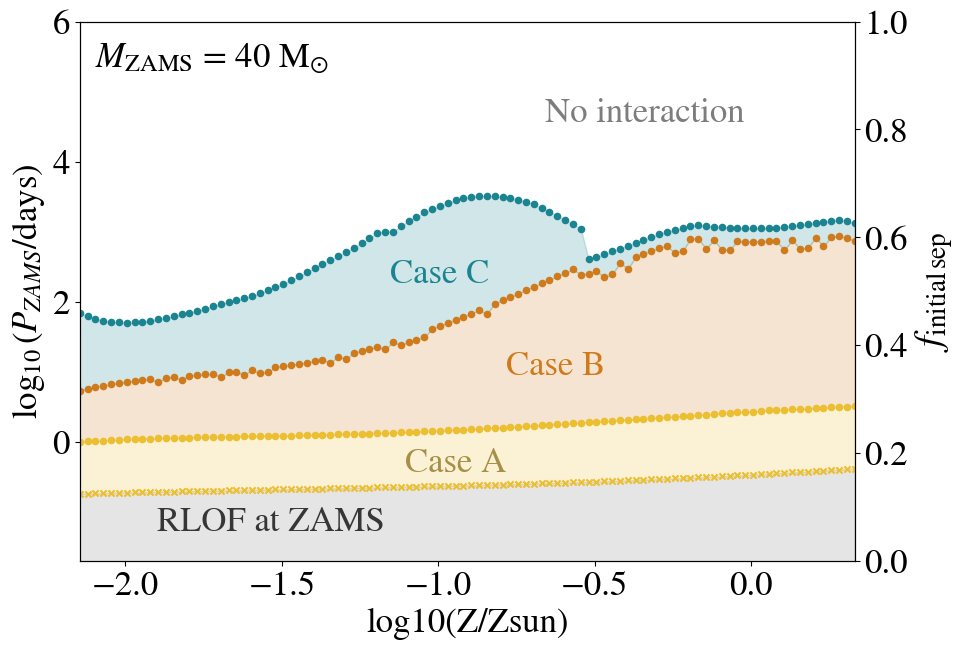

mass 10 0


/tmp/ipykernel_157258/3519363226.py:29: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(Kepler3(data['maxR_FGB'][mi],mass, mass) ), c = "#72bfc2", s = 20, label = "FGB")


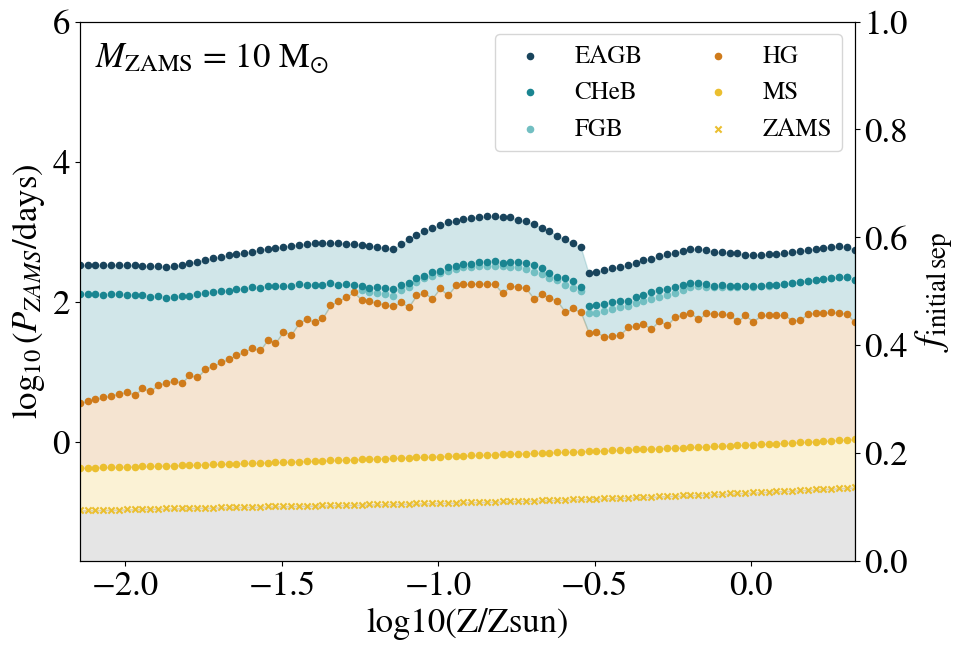

In [61]:


def plot_PZAMS_CaseABC(mass, show_legend = True, show_annotations = False):
    """
    Plot the maximum radius for each type of star as a function of metallicity
    """
    mi = data['M0'].index(mass)
    print('mass', mass, mi)

    fig, ax = plt.subplots(figsize =(10,7))

    plt.fill_between(np.log10(np.array(data['Metals'][mi])/0.014), y1 =-2, y2 = np.log10(Kepler3(data['R_ZAMS'][mi],mass, mass) ),  color = 'grey', alpha = 0.2)

    # R_ZAMS
    plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(Kepler3(data['R_ZAMS'][mi],mass, mass) ), c = '#ebbf2f', s = 20, marker = 'x', label = 'ZAMS')

    # Case A is up to max MS
    plt.fill_between(np.log10(np.array(data['Metals'][mi])/0.014), y1 = np.log10(Kepler3(data['R_ZAMS'][mi],mass, mass) ), y2 = np.log10(Kepler3(data['maxR_MS'][mi],mass, mass) ),  color = '#ebbf2f', alpha = 0.2)

    #Case B is between MS and HG 
    plt.fill_between(np.log10(np.array(data['Metals'][mi])/0.014), y1 = np.log10(Kepler3(data['maxR_MS'][mi], mass, mass) ), y2 = np.log10(Kepler3(data['maxR_HG'][mi],mass, mass) ),  color = '#cf7b1b', alpha = 0.2)

    # Case C is beyond HG
    plt.fill_between(np.log10(np.array(data['Metals'][mi])/0.014), y1 = np.log10(Kepler3(data['maxR_HG'][mi],mass, mass) ), y2 = np.log10(Kepler3(data['maxRadii'][mi],mass, mass) ),  color = '#1a8591', alpha = 0.2)

    # Per types
    plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(Kepler3(data['maxR_MS'][mi],mass, mass) ), c = '#ebbf2f', s = 20, label = 'MS')

    plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(Kepler3(data['maxR_HG'][mi],mass, mass) ), c = "#cf7b1b", s = 20, label = "HG")

    plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(Kepler3(data['maxR_FGB'][mi],mass, mass) ), c = "#72bfc2", s = 20, label = "FGB")

    plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(Kepler3(data['maxR_CHeB'][mi],mass, mass) ), c = "#1a8591", s = 20, label = "CHeB")

    plt.scatter(np.log10(np.array(data['Metals'][mi])/0.014), np.log10(Kepler3(data['maxR_EAGB'][mi],mass, mass) ), c = "#19445c", s = 20, label = "EAGB")


    # Add a second axis on the right
    r_ax = ax.twinx()    
    # r_ax = ax.secondary_yaxis('right')
    r_ax.set_ylabel('$f_{\mathrm{initial\, sep}}$', size = 28)



    ax.text(0.02, 0.9, r'$M_{\rm ZAMS}$ = %s M$_{\odot}$'%(mass), transform=ax.transAxes, 
            ha = 'left', va = 'bottom', size = 25)
    

    if show_annotations:
        ax.text(0.1, 0.07, 'RLOF at ZAMS', ha='left', va='center', c = '#363636', size = 25, transform=ax.transAxes)
        ax.text(0.42, 0.18, 'Case A ', ha='left', va='center', c = '#a68f46', size = 25, transform=ax.transAxes)
        ax.text(0.55, 0.36,'Case B', ha='left', va='center', c = '#cf7b1b',size = 25, transform=ax.transAxes)
        ax.text(0.4, 0.53, 'Case C', ha='left', va='center', c = '#1a8591', size = 25, transform=ax.transAxes)
        ax.text(0.6, 0.83, 'No interaction', ha='left', va='center', c = '#7d7d7d', size = 25, transform=ax.transAxes)

    # Plotvalues
    if show_legend:
        handles, labels = ax.get_legend_handles_labels() # Reverse legend order
        ax.legend(handles[::-1], labels[::-1], loc = 'upper right', ncols = 2)
    ax.set_xlabel('log10(Z/Zsun)')
    ax.set_xlim(np.log10(1e-4/0.014), np.log10(0.03/0.014))
    ax.set_ylim(-1.7, 6)
    ax.set_ylabel('$\log_{10} (P_{ZAMS}$/days)')
    # plt.savefig(proj_dir + f'/plots/MaxR_Type_perZ_M{mass}_{var_name}_{version}.pdf',bbox_inches='tight')

    # Make a plot dir in the data dir if it doesnt exist yet
    if not os.path.exists(f'{root_out_dir}/plots/'):
        os.makedirs(f'{root_out_dir}/plots/')
    plt.savefig(f'../plots/PZAMS_Type_perZ_M{mass}.pdf',bbox_inches='tight')

    plt.show()

plot_PZAMS_CaseABC(40, show_legend = False, show_annotations = True)
plot_PZAMS_CaseABC(10)